- Inputs (either/or):
    - Binary vectors (Bernoulli)
    - bipolar vectors (Rademacher)
    - real values vectors (Gaussian)
- Objectives (either/or):
    - classify perfect match vs every other vector under varying SNR
    - maximize information gain
- Thresholds (either/or):
    - uniformly spaced
    - symmetric but non-uniformly spaced
    - arbitrarily spaced

In [2]:
!pip install -q jax jaxlib numpyro numpy matplotlib funsor seaborn xarray
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import xarray
from jax import random, vmap

import numpyro
import numpyro.distributions as dists
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns


/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def compute_thresholds(
    num_bits: int,
    phase: jnp.ndarray,
    scale: jnp.ndarray,
    distribution: str,
    vector_length: int,
):
    if distribution == "bipolar":
        thr = (
            (
                (
                    jnp.arange((1 << num_bits) + 1)
                    - (1 << (num_bits - 1))
                    + jnp.atleast_1d(phase)[..., jnp.newaxis]
                )
                * jnp.atleast_1d(scale)[..., jnp.newaxis]
                * 2
            )
            .at[..., -1]
            .set(jnp.inf)
            .at[..., 0]
            .set(-jnp.inf)
        )
    elif distribution == "binary":
        thr = (
            (
                (
                    jnp.arange((1 << num_bits) + 1)
                    - (1 << (num_bits - 1))
                    + vector_length / 2
                    + 0.5
                    + jnp.atleast_1d(phase)[..., jnp.newaxis]
                )
                * jnp.atleast_1d(scale)[..., jnp.newaxis]
            )
            .at[..., -1]
            .set(jnp.inf)
            .at[..., 0]
            .set(-jnp.inf)
        )
    return thr.astype(jnp.float_)

In [4]:
def log_pdf_n(n, vector_length: int, distribution: str = "binary", fixed: int = None):
    """
    Compute the log-probability of getting the integer sum x from summing two random vectors of length vector_length.

    This assumes i.i.d values, where:
        - the product between two binary random variables is a Bernoulli random variable with p=0.25.
        - the product between two bipolar random variables is a Rademacher random variable with p=0.5.

    If 'fixed' is specified, that many elements are assumed to be deterministically set to the same value in the two vectors.
    """
    if fixed is None:
        fixed = 0

    if distribution == "binary":
        p = 0.25
        scale = 1
        offset = 0
    elif distribution == "bipolar":
        # for bipolar: r random matches + fixed matches => vector_length - (r + fixed) mismatches
        # => n = (r + fixed) - (vector_length - (r + fixed)) = 2(r + fixed) - vector_length
        # => r = (n + vector_length) / 2 - fixed
        p = 0.5
        scale = 2
        offset = -vector_length

    return jnp.where(
        (n - offset) % scale == 0,
        dists.Binomial(vector_length - fixed, p).log_prob((n - offset) // scale),
        -jnp.inf,
    )


# drawing n=0 from 10 bipolar values with 4 fixed draws
# should be the same as drawing 1 matching and 5 mismatching from 6 binary values
assert log_pdf_n(0, 10, "bipolar", fixed=4) == dists.Binomial(6, 0.5).log_prob(
    1
), "Value mismatch"
from functools import partial


def log_pdf_x_n(x, n, noise_std: float = 0.1):
    """
    Compute the log-probability of observing the noisy real measurement x given the true integer product n.
    """
    return dists.Normal(n, noise_std).log_prob(x)

def log_pdf_x(x, vector_length: int, noise_std: float = 0.1, distribution: str = "bipolar", fixed=0):
    """
    Compute the log-probability of observing the noisy real measurement x.
    """

    trial_dims = jnp.broadcast_shapes(jnp.shape(noise_std), jnp.shape(fixed), jnp.shape(x))

    if distribution == "binary":
        ns = jnp.arange(vector_length+1)
    elif distribution == "bipolar":
        ns = jnp.arange(-vector_length, vector_length+1, 2)

    ns = ns[:, *(jnp.newaxis,)*len(trial_dims)]
    x = jnp.atleast_1d(x)[jnp.newaxis, ...]
    noise_std = jnp.atleast_1d(noise_std)[jnp.newaxis, ...]
    fixed = jnp.atleast_1d(fixed)[jnp.newaxis, ...]

    log_probs = log_pdf_x_n(x, ns, noise_std) + log_pdf_n(ns, vector_length, distribution, fixed=fixed)

    return jax.scipy.special.logsumexp(log_probs, axis=0, keepdims=False)

def log_pdf_y_n(y, n, thresholds: jnp.ndarray, noise_std: float = 0.1):
    """
    Compute the log-probability of observing the quantized measurement y given the true integer product n.
    """

    #print(
        # f"Thresholds: {thresholds.shape}, Y: {y.shape}, Thresholds[Y]: {thresholds[y].shape}"
    # )

    shape = jnp.broadcast_shapes(thresholds.shape[:-1], jnp.shape(y), jnp.shape(n), jnp.shape(noise_std))
    y = jnp.broadcast_to(y, shape)
    n = jnp.broadcast_to(n, shape)
    noise_std = jnp.broadcast_to(noise_std, shape)

    d = dists.Normal(n, noise_std)
    idx = jnp.ix_(*[jnp.arange(i) for i in shape])

    return jnp.log((d.cdf(thresholds[*idx, y + 1]) - d.cdf(thresholds[*idx, y])))


def log_pdf_yn(
    y,
    n,
    thresholds: jnp.ndarray,
    noise_std: float = None,
    vector_length: int = None,
    distribution: str = None,
    fixed=None,
):
    """
    Compute the joint log-probability of observing the quantized measurement y and the true integer product n.
    """

    #print("Y, N:", y.shape, n.shape)

    res1 = log_pdf_y_n(y, n, thresholds, noise_std)
    res2 = log_pdf_n(
        n, vector_length=vector_length, distribution=distribution, fixed=fixed
    )
    # print(
    #     f"log P(Y|N): {res1.shape}, log P(N): {res2.shape}, log P(Y,N): {(res1+res2).shape}"
    # )
    return res1 + res2


def log_pdf_y(
    y,
    thresholds: jnp.ndarray,
    noise_std: float = None,
    vector_length: int = None,
    distribution: str = None,
    fixed=0,
):
    """
    Compute the log-probability of observing the quantized measurement y.
    """

    if distribution == "binary":
        ns = jnp.arange(vector_length+1)
    elif distribution == "bipolar":
        ns = jnp.arange(-vector_length, vector_length+1, 2)

    trial_dims = jnp.broadcast_shapes(jnp.shape(thresholds)[:-1], jnp.shape(noise_std), jnp.shape(fixed), jnp.shape(y))

    ns = ns[:, *(jnp.newaxis,)*len(trial_dims)]
    y = jnp.atleast_1d(y)[jnp.newaxis, ...]
    thresholds = jnp.atleast_1d(thresholds)[jnp.newaxis, ...]
    noise_std = jnp.atleast_1d(noise_std)[jnp.newaxis, ...]
    fixed = jnp.atleast_1d(fixed)[jnp.newaxis, ...]

    terms = log_pdf_yn(y, ns, thresholds, noise_std, vector_length, distribution, fixed)
    res = jax.scipy.special.logsumexp(terms, axis=0, keepdims=False)
    #print(y.shape, terms.shape, res.shape)
    return res


@partial(jax.jit, static_argnames=("vector_length", "distribution"))
def MIbits(
    vector_length: int,
    thresholds: jnp.ndarray,
    noise_std: float = 0,
    distribution: str = "bipolar",
    fixed=0,
):
    """
    Compute the mutual information between the quantized measurement y and the true product n.
    """
    
    trial_dims = jnp.broadcast_shapes(jnp.shape(thresholds)[:-1], jnp.shape(noise_std), jnp.shape(fixed))

    # map over all possible combinations of y and n
    ys = jnp.arange(thresholds.shape[-1]-1)

    if distribution == "binary":
        ns = jnp.arange(vector_length + 1)
    elif distribution == "bipolar":
        ns = jnp.arange(-vector_length, vector_length+1, 2)

    # add extra dimensions to ys and ns to sum over
    ys = ys[:, jnp.newaxis, *(jnp.newaxis,)*len(trial_dims)]
    ns = ns[jnp.newaxis, :, *(jnp.newaxis,)*len(trial_dims)]
    noise_std = jnp.array(noise_std)[jnp.newaxis, jnp.newaxis, ...]
    fixed = jnp.array(fixed)[jnp.newaxis, jnp.newaxis, ...]
    thresholds = thresholds[jnp.newaxis, jnp.newaxis, ...]

    # compute the probabilities
    l_p_y_n = log_pdf_y_n(ys, ns, thresholds, noise_std)
    l_p_y = log_pdf_y(ys, thresholds, noise_std, vector_length, distribution, fixed=fixed)
    l_p_n = log_pdf_n(ns, vector_length, distribution, fixed=fixed)
    l_p_yn = l_p_n + l_p_y_n
        
    # compute the log of each summand term
    # log2(p_y_n/p_y) = log2(p_y_n) - log2(p_y) = (log(p_y_n) - log(p_y)) / log(2)
    summand = jnp.exp(l_p_yn) * (l_p_y_n - l_p_y)/jnp.log(2)

    # sum over all possible values of y and n where the probability is >0
    res = jnp.sum(summand, axis=(0,1), keepdims=False, where=jnp.isfinite(summand))
    return res

In [5]:

def sweep(
    vector_length: int,
    num_bits: jnp.ndarray,
    phase: jnp.ndarray,
    scale: jnp.ndarray,
    noise_std: jnp.ndarray,
    distribution: str = None,
    fixed: jnp.ndarray = jnp.array([0]),
    to_xarray: bool = True,
):
    # reshape parameters:
    # - 0th dimension: number of ADC bits (added by looping)
    # - 1st dimension: number of fixed bits
    # - 2nd dimension: noise standard deviation
    # - 3rd dimension: phase offset
    # - 4th dimension: scale factor
    (
        fixed,
        noise_std,
        phase,
        scale,
    ) = jnp.ix_(fixed, noise_std, phase, scale)

    num_bits = jnp.atleast_1d(num_bits)

    MIs = []
    for b in num_bits:
        # compute thresholds
        thresholds = compute_thresholds(b, phase, scale, distribution, vector_length)

        MIs.append(
            MIbits(
                vector_length=vector_length,
                thresholds=thresholds,
                noise_std=noise_std,
                distribution=distribution,
                fixed=fixed,
            )
        )

    res = jnp.stack(MIs, axis=0)

    if to_xarray:
        res = xarray.DataArray(
            res,
            dims=("num_bits", "fixed", "noise_std", "phase", "scale"),
            coords={
                "num_bits": num_bits.ravel(),
                "fixed": fixed.ravel(),
                "noise_std": noise_std.ravel(),
                "phase": phase.ravel(),
                "scale": scale.ravel(),
            },
        )

    return res

In [6]:
from typing import Union


def model(
    vector_length: int,
    distribution: Union[dists.Distribution, str] = "bipolar",
    noise_std: float = 0.1,
    thresholds: jnp.ndarray = jnp.array([0.5]),
):
    scale = 1.0
    offset = 0.0

    if isinstance(distribution, str):
        if distribution == "normal":
            distribution = dists.Normal(0, 1)
        elif distribution == "binary":
            distribution = dists.Bernoulli(0.5)
        elif distribution == "bipolar":
            distribution = dists.Bernoulli(0.5)
            scale = 2.0
            offset = -1.0
        else:
            raise ValueError(f"Unknown distribution: {distribution}")

    # v1, v2: the two random vectors to be correlated
    with numpyro.plate("vectors", vector_length):
        v1 = numpyro.sample("v1", distribution) * scale + offset
        v2 = numpyro.sample("v2", distribution) * scale + offset

    # Compute correct product
    n = numpyro.deterministic("n", jnp.dot(v1, v2))

    # Compute the noisy measurement
    x = numpyro.sample("x", dists.Normal(n, noise_std))

    # compute the quantized version of the noisy measurement
    y = numpyro.deterministic("y", jnp.searchsorted(thresholds, x))

/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


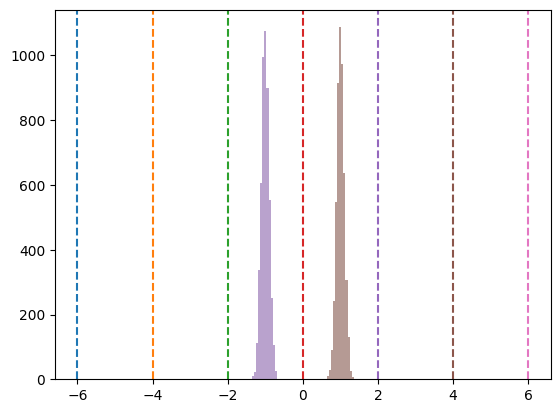

In [7]:
xmin, xmax = -5.5, 5.5
rng_key, rng_key_ = random.split(random.PRNGKey(0))

noise_std = 0.1
vector_length = 1
fixed = 0
distribution = "bipolar"
thresholds = compute_thresholds(num_bits=3, phase=0, scale=1, distribution="bipolar", vector_length=vector_length).ravel()

trace = Predictive(model, {}, num_samples=10000)(
    rng_key_, vector_length=vector_length, distribution=distribution, thresholds=thresholds
)

x_inset = jnp.take(
    trace["x"], jnp.where((xmin <= trace["x"]) * (trace["x"] <= xmax))[0]
)

bins = jnp.linspace(xmin, xmax, 200)

# sns.kdeplot(x_inset, label="x", gridsize=1000)
plt.hist(x_inset, bins=bins, alpha=0.5, label="x", color="silver")

for i, threshold in enumerate(thresholds[1:-1]):
    # compute x-values for each class
    x_y = jnp.take(trace["x"], jnp.where(trace["y"] == i)[0])
    plt.axvline(threshold, color=f"C{i}", linestyle="--")
    plt.hist(x_y, bins=bins, alpha=0.5, label=f"y={i}", color=f"C{i}")

In [8]:
MIbits(vector_length=vector_length, thresholds=thresholds, noise_std=noise_std, distribution="bipolar", fixed=fixed)
# MI(12, thresholds, noise_std=0.1, distribution="bipolar")

Array(1., dtype=float64)

In [9]:
jnp.exp(log_pdf_n(1, vector_length=vector_length, distribution=distribution))

Array(0.5, dtype=float64)

In [10]:
jnp.exp(log_pdf_y_n(jnp.array([[0,1]]), jnp.array([[-1],[0],[1]]), thresholds[None,None,...], noise_std=noise_std))

Array([[0.00000000e+000, 4.90671393e-198],
       [0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000]], dtype=float64)

In [11]:
jnp.exp(log_pdf_yn(jnp.array([[0,1]]), jnp.array([[-1],[0],[1]]), thresholds[None,None,...], noise_std=noise_std, vector_length=vector_length, distribution=distribution))

Array([[0.00000000e+000, 2.45335696e-198],
       [0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000]], dtype=float64)

In [12]:
jnp.exp(log_pdf_y(jnp.array([-1, 0, 1, 2]), thresholds[None,...], noise_std=noise_std, vector_length=vector_length, distribution=distribution))

Array([            nan, 0.00000000e+000, 2.45335696e-198, 3.80992651e-024],      dtype=float64)

In [13]:
vector_length = 256
num_bits = np.arange(1,jnp.log2(vector_length).astype(int)+1)
phase = np.linspace(-0.75, 0.75, 100)
scale = np.linspace(0.01, 5, 100)

noise_std = jnp.array([0.1, 0.25, 0.5, 1.0])
fixed = np.arange(0, 3)

MIs = sweep(
    vector_length,
    num_bits,
    phase,
    scale,
    noise_std,
    distribution="bipolar",
    fixed=jnp.array([0]),
)
MIs

In [14]:
MIs.isel(fixed=0, noise_std=0).squeeze()

<xarray.DataArray (num_bits: 8, phase: 100, scale: 100)> Size: 640kB
Array([[[0.95066757, 0.9611157 , 0.97752687, ..., 0.92859131,
         0.90724647, 0.89126302],
        [0.9506482 , 0.96072951, 0.97681321, ..., 0.95267283,
         0.94466244, 0.92869188],
        [0.95062922, 0.96034738, 0.97609062, ..., 0.95604471,
         0.95543572, 0.95288686],
        ...,
        [0.95062922, 0.96034738, 0.97609062, ..., 0.95604471,
         0.95543572, 0.95288686],
        [0.9506482 , 0.96072951, 0.97681321, ..., 0.95267283,
         0.94466244, 0.92869188],
        [0.95066757, 0.9611157 , 0.97752687, ..., 0.92859131,
         0.90724647, 0.89126302]],

       [[0.98542527, 1.09684111, 1.13249144, ..., 1.77889417,
         1.75319401, 1.73159403],
        [0.98541884, 1.09768553, 1.13485998, ..., 1.83816157,
         1.83892048, 1.81888139],
        [0.98541254, 1.09851969, 1.13721367, ..., 1.88158838,
         1.88445101, 1.88233676],
...
        [1.23580894, 2.53180676, 3.24790068, ..., 3.05135514,
         3.02584335, 3.04490131],
        [1.23580894, 2.53171688, 3.24790072, ..., 3.04942999,
         2.99824269, 2.93512537],
        [1.23580894, 2.53162376, 3.24790077, ..., 3.04873688,
         2.98489023, 2.81380515]],

       [[1.6935131 , 3.55159678, 4.55525227, ..., 3.04873688,
         2.98489023, 2.81380515],
        [1.6935131 , 3.55159678, 4.55525227, ..., 3.04942999,
         2.99824269, 2.93512537],
        [1.6935131 , 3.55159678, 4.55525227, ..., 3.05135514,
         3.02584335, 3.04490131],
        ...,
        [1.6935131 , 3.55159678, 4.55525227, ..., 3.05135514,
         3.02584335, 3.04490131],
        [1.6935131 , 3.55159678, 4.55525227, ..., 3.04942999,
         2.99824269, 2.93512537],
        [1.6935131 , 3.55159678, 4.55525227, ..., 3.04873688,
         2.98489023, 2.81380515]]], dtype=float64)
Coordinates:
  * num_bits   (num_bits) int64 64B 1 2 3 4 5 6 7 8
    fixed      int64 8B 0
    noise_std  float64 8B 0.1
  * phase      (phase) float64 800B -0.75 -0.7348 -0.7197 ... 0.7197 0.7348 0.75
  * scale      (scale) float64 800B 0.01 0.0503 0.09061 ... 3.919 3.96 4.0

/var/folders/2t/lcrnl5t504q810ckz7k6ggtm0000gn/T/ipykernel_4261/3511726329.py:11: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  fg.axes[i,k].set_title(f"{int(n)} bits, noise_std={float(s):.2f}")
/var/folders/2t/lcrnl5t504q810ckz7k6ggtm0000gn/T/ipykernel_4261/3511726329.py:12: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  fg.axes[i,k].plot(max_phase[i,j,k], max_scale[i,j,k], "kx")


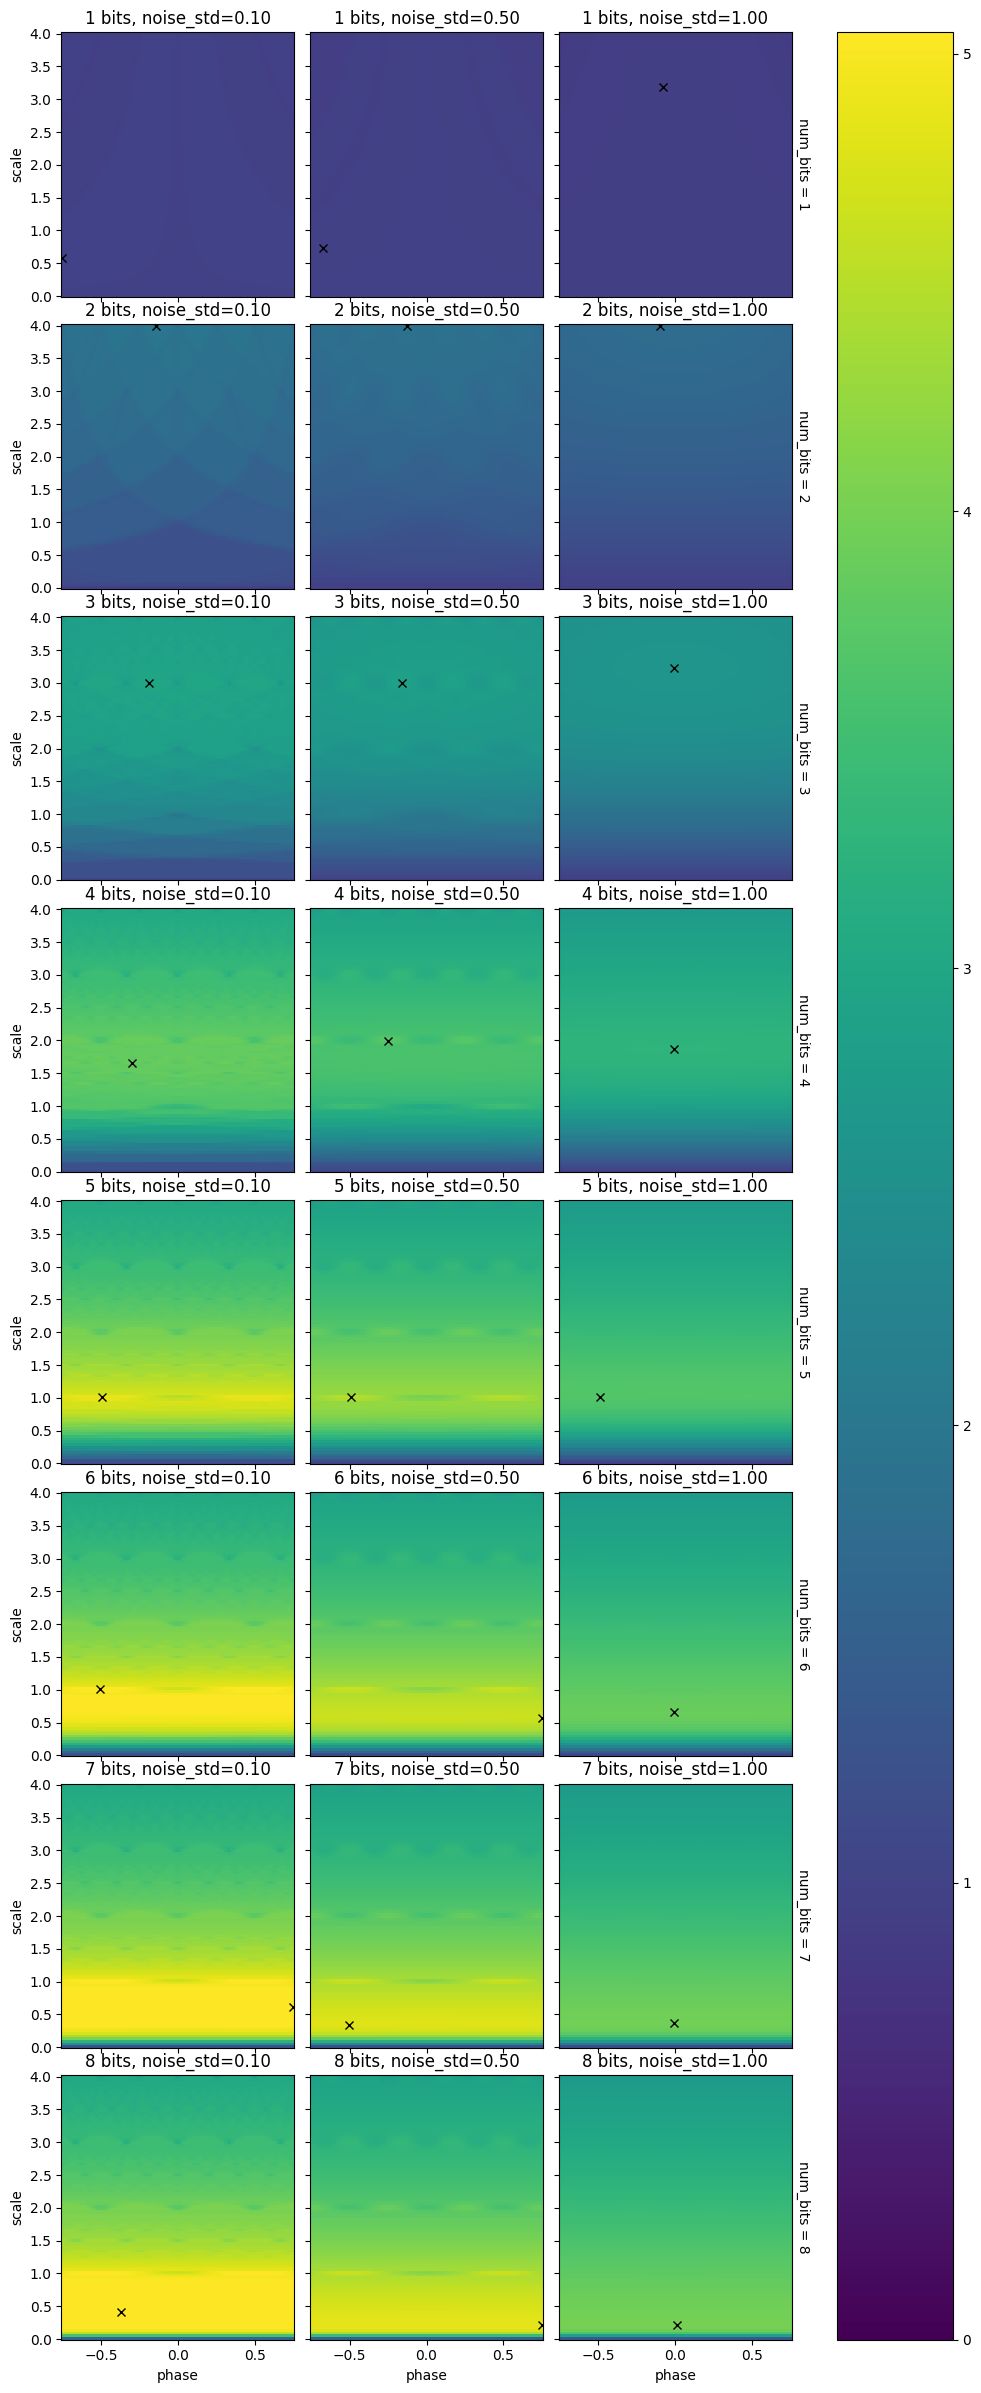

In [15]:
fg = MIs.isel(fixed=0).squeeze().plot(row="num_bits", col="noise_std", x="phase", y="scale", cmap="viridis", vmin=0)
max_idx = MIs.argmax(dim=("phase", "scale"))

max_phase = MIs.coords["phase"][max_idx["phase"]]
max_scale = MIs.coords["scale"][max_idx["scale"]]
max_MI = MIs.max(dim=("phase", "scale"))

for i,n in enumerate(MIs.coords["num_bits"]):
    for j,f in enumerate(MIs.coords["fixed"]):
        for k,s in enumerate(MIs.coords["noise_std"]):
            fg.axes[i,k].set_title(f"{int(n)} bits, noise_std={float(s):.2f}")
            fg.axes[i,k].plot(max_phase[i,j,k], max_scale[i,j,k], "kx")

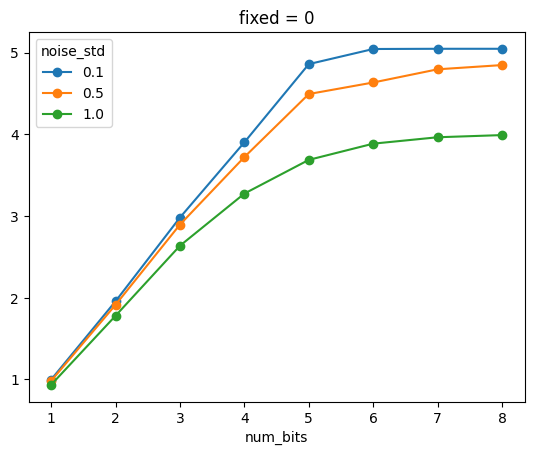

In [16]:
max_MI.squeeze().plot(x="num_bits", hue="noise_std", marker="o")

In [17]:
def plot_thresholds(ax, thresholds, noise_std: float, fixed: int, distribution: str, vector_length: int, line_kwargs=dict(linestyle=":", linewidth=1, color="gray")):
    if distribution == "binary":
        xx = np.linspace(-1, vector_length+1, 10001)
    elif distribution == "bipolar":
        xx = np.linspace(-vector_length-1, vector_length+1, 10001)
    
    p_x = jnp.exp(log_pdf_x(xx, noise_std=noise_std, vector_length=vector_length, distribution=distribution, fixed=fixed))
    ax.plot(xx, p_x)

    max_p = p_x.max()

    ax.set_ylim(-max_p*0.05, max_p*1.05)
    ax.set_xlim(float(thresholds[1])-2, float(thresholds[-2])+2)

    ax.vlines(thresholds, -max_p*0.05, max_p*1.05, **line_kwargs)
    

In [202]:


def plot_panel(num_bits_idx, fixed_idx, noise_std_idx, ax=None, fig_kwargs=dict(figsize=(6,6)), threshold_kwargs=dict(linestyle=":", linewidth=1, color="black"), inside_color="C0", outside_color="C1"):
    if ax is None:
        fig, (ax, ax_zoomed) = plt.subplots(2,1, **fig_kwargs)
    else:
        fig = ax[0].get_figure()
        ax, ax_zoomed = ax
    
    # extract the precise parameters to plot
    phase = float(max_phase[dict(num_bits=num_bits_idx, fixed=fixed_idx, noise_std=noise_std_idx)])
    scale = float(max_scale[dict(num_bits=num_bits_idx, fixed=fixed_idx, noise_std=noise_std_idx)])
    num_bits = int(MIs.coords["num_bits"][num_bits_idx])
    fixed = int(MIs.coords["fixed"][fixed_idx])
    noise_std = float(MIs.coords["noise_std"][noise_std_idx])

    # compute the optimal thresholds for the given parameters
    opt_thresholds = compute_thresholds(num_bits, phase, scale, distribution=distribution, vector_length=vector_length).ravel()
    tmin, tmax = float(opt_thresholds[1]), float(opt_thresholds[-2])
    xmin, xmax = tmin-10, tmax+10

    # compute the "background" probability distribution
    nn = np.arange(vector_length+1)
    if distribution == "bipolar":
        nn = nn * 2 - vector_length
    # pp = np.exp(dists.Binomial(vector_length, 0.5).log_prob(xx))
    p_n = jnp.exp(log_pdf_n(nn, vector_length=vector_length, distribution=distribution, fixed=fixed))

    ymin, ymax = -p_n.max()*0.05, p_n.max()*1.05

    # create the overview plot
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor="black", facecolor="none"))
    # ax.fill_between(nn, ymax, p_n, where=(nn >= xmin) * (nn <= xmax), color=threshold_color)
    ax.fill_between(nn, p_n, 0, where=(nn >= tmin) * (nn <= tmax), color=inside_color, alpha=0.5)
    ax.fill_between(nn, p_n, 0, where=np.logical_not((nn >= tmin) * (nn <= tmax)), color=outside_color, alpha=0.5)
    # ax.vlines([opt_thresholds[1],opt_thresholds[-2]], 0, ymax, color=threshold_color)
    ax.plot(nn, p_n, color="gray")

    # create the zoomed-in plot
    xx = np.linspace(xmin, xmax, 1001)

    p_x = jnp.exp(log_pdf_x(xx, noise_std=noise_std, vector_length=vector_length, distribution=distribution, fixed=fixed))
    p_n = jnp.exp(log_pdf_n(nn, vector_length=vector_length, distribution=distribution, fixed=fixed))

    idx_in = (tmin <= xx) * (xx <= tmax)
    ax_zoomed.fill_between(xx, p_x, 0, where=idx_in, color=inside_color, alpha=0.5)
    ax_zoomed.fill_between(xx, p_x, 0, where=np.logical_not(idx_in), color=outside_color, alpha=0.5) 
    ax_zoomed.plot(xx, p_x, color="gray")
    ax_zoomed.twinx().plot(nn, p_n, "-", color="gray")

    ymin, ymax = -p_x.max()*0.05, p_x.max()*1.05
    ax_zoomed.set_ylim(ymin, ymax)
    ax_zoomed.set_xlim(xmin, xmax)

    ax_zoomed.vlines(opt_thresholds, ymin, ymax, **threshold_kwargs)
    fig.tight_layout()
    return fig, ax

(<Figure size 640x480 with 3 Axes>, <Axes: >)

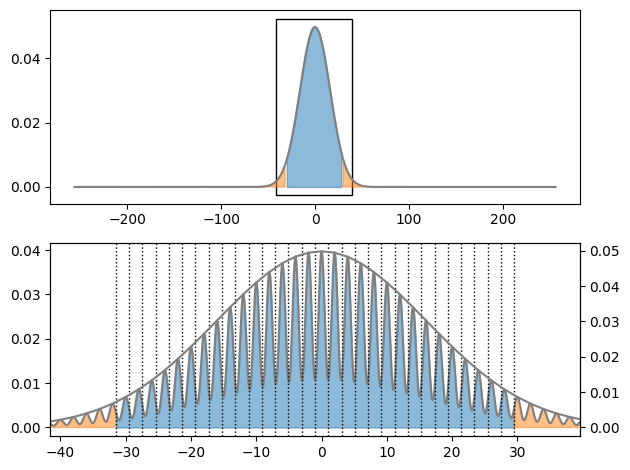

In [203]:
fig,ax = plt.subplots(2, 1)

num_bits_idx = 4
fixed_idx = 0
noise_std_idx = 1
plot_panel(num_bits_idx, fixed_idx, noise_std_idx, ax=ax)

(<Figure size 600x600 with 3 Axes>, <Axes: >)

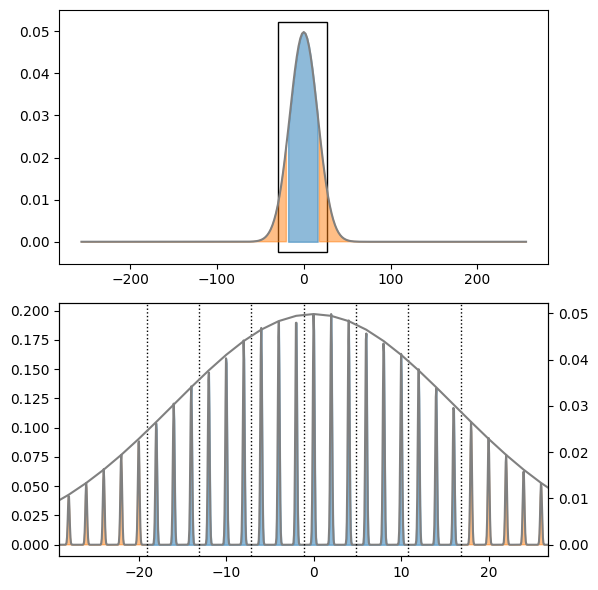

In [205]:
num_bits_idx = 2
fixed_idx = 0
noise_std_idx = 0
plot_panel(num_bits_idx, fixed_idx, noise_std_idx)